In [1]:
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np

2022-03-11 10:45:39,926.926 DEBUG __init__:  matplotlib data path: /home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data
2022-03-11 10:45:39,929.929 DEBUG __init__:  CONFIGDIR=/home/nsmy/.config/matplotlib
2022-03-11 10:45:39,931.931 DEBUG __init__:  interactive is False
2022-03-11 10:45:39,931.931 DEBUG __init__:  platform is linux
2022-03-11 10:45:39,931.931 DEBUG __init__:  loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', '

# Text processing

In [2]:
# Speaker
speakers = ["z21", "z20", "z28", "z29"]
models = ["google", "correct", "kb"]
models2fnameendings = {
    "google": "googleasr",
    "correct": "correct",
    "kb": "kb"
}
use_new = False

# Create filenames model -> List[List[str]] (List[str] are the lines from one filename
fnames = {model: [f"transcriptions{'_new' if use_new else ''}/{sp}.{models2fnameendings[model]}" for sp in speakers]
          for model in models}

bunches = {model: [get_fname_lines(fname) for fname in fnames] for model, fnames in fnames.items()}

# speakerLines : List[str]
# bunch List[speakerLines]
# bunches Dict[model, List[speakerLines]]

# Create a list [Dict[model,speakerlines] for speaker]

list_of_model2speaker_lines = [{model: bunch[i] for model, bunch in bunches.items()} for i in range(len(speakers))]
[fix_lines(x) for x in list_of_model2speaker_lines]
# recreate bunches Dict[model, List[speakerLines]]
bunches = {x: [list_of_model2speaker_lines[i][x] for i in range(len(speakers))] for x in models}
# Reduce bunches to bunches_reduced Dict[model, speakerLines_aggr]
bunches = {k: reduce(lambda x, y: x + y, v) for k, v in bunches.items()}
# Extract the transcriptions
bunches = {k: transcriptions(v) for k, v in bunches.items()}
# Preprocess  each transcription
bunches = {k: [preprocess_text(x) for x in v] for k, v in bunches.items()}

# Initialize phonemizer
phonemizer = init_phonemizer("cuda", "./models/deep-phonemizer-se.pt")

In [3]:
from IPython.core.debugger import set_trace

In [4]:
def singular_phonemes(txt : str):
    """
    Creates a list of singular phonemes from the
    output of get_swedish_phonemes
    """
    return txt.replace("_", " ").split()

def singular_phonemes_preprocess(bunches):
    return {k: [" ".join(singular_phonemes(s)) for s in v] for k,v in bunches.items()}

def get_swedish_phonemes_z(bunches, phonemizer,stress_marks=True):
    # Phonemizer creates a dict of words2phonemes for each line, so it 
    # so all phonemes should be created with a single call for consistency
    # Impose an order to models
    models = list(bunches.keys())
    num_lines = len(bunches["google"])
    concatenated = reduce(lambda x,y : x+y,[bunches[x] for x in models])
    phoneme_lines = get_swedish_phonemes(concatenated, phonemizer, include_stress_marks=stress_marks)
    return { model : phoneme_lines[num_lines * i:num_lines * (i+1)] for model,i in zip(models,range(0,len(models)))}

# Experiments

In [5]:
def preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks):
    if phoneme_words:
        bunches = get_swedish_phonemes_z(bunches, phonemizer, stress_marks=stress_marks)
        #
        bunches = {k : [preprocess_phonemes(x) for x in v] for k,v in bunches.items()}
              
    if singular_phonemes:
        bunches = get_swedish_phonemes_z(bunches, phonemizer, stress_marks=stress_marks)
        bunches = singular_phonemes_preprocess(bunches)
    

    if preprocess_hook is not None:
        preprocess_hook(**locals())

    if _filter is not None:
        if len(_filter) == 1 and "agreement" in _filter:
            bunches = filter_bunches_only_on_agreement(bunches, _filter["agreement"])
        else:
            bunches = filter_bunches(bunches,**_filter)
        
    return {
        "bunches" : bunches
    }

def google_kb_wer(bunches):
    return {
        "google_wer" : wer(bunches["correct"], bunches["google"]),
        "kb_wer" : wer(bunches["correct"], bunches["kb"]),
    }
def sentence_lengths(bunches):
    return {k+"-avg-length" : mean([len(x.split(" ")) for x in v]) for k,v in bunches.items()}

def eoi(bunches):
    kei = 0
    oei = 0
    gei = 0
    tei = 0

    for c_l, g_l, kb_l in zip(bunches["correct"], bunches["google"], bunches["kb"]):
        g_s = set(error_idxs(c_l, g_l))
        k_s = set(error_idxs(c_l, kb_l))

        gei += len(g_s)
        kei += len(k_s)
        oei += len(g_s & k_s)
        tei += len(g_s | k_s)

    error_index_overlap = oei / tei
    
    return {"error_index_overlap": error_index_overlap}

def lcs_percentage(bunches):
    lcses = []
    
    for c_l, g_l, kb_l in zip(bunches["correct"], bunches["google"], bunches["kb"]):
        total_length_before = len(g_l.split(" ")) + len(kb_l.split(" "))
        words_set = set(g_l.split(" ") + kb_l.split(" "))
        w2char = { x : chr(i) for i,x in enumerate(words_set)}
        g_l_enc = "".join([w2char[w] for w in g_l.split(" ")])
        kb_l_enc = "".join([w2char[w] for w in kb_l.split(" ")])
        assert total_length_before == (len(g_l_enc) + len(kb_l_enc))
        
        s = SequenceMatcher(None, g_l_enc, kb_l_enc)
        lcs = ''.join([g_l_enc[block.a:(block.a + block.size)] for block in s.get_matching_blocks()])
        lcses.append(len(lcs)/ len(c_l.split(" ")))
    
    return {"lcs-mean": mean(lcses)}
          
def agreement_percentages(bunches): 
   
    agreement, g_correct_kb_not, kb_correct_g_not, agreement_not_correct, agreement_correct,\
    both_incorrect_disagreement =\
        percentage_of_agreement(bunches)
    
    return {  
        "agreement" : agreement,
        "g_correct_kb_not " : g_correct_kb_not,
        "kb_correct_g_not " : kb_correct_g_not,
        "agreement_not_correct" :  agreement_not_correct,
        "both_incorrect_disagreement" : both_incorrect_disagreement,
    }

def parameterized_agreement(bunches, _filter=None, phoneme_words=None, singular_phonemes=None, 
                            preprocess_hook=None, stress_marks=None, trusted_model=None, threshold_range=None):
    """
    Trusted model: Which model to fall back to when there is no agreement
    """
    bunches = preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks)["bunches"]
    threshold_levels = np.linspace(*threshold_range)
    # bunches : DL
    wers= []
    agreement_ratios = []
    
    for t in threshold_levels:
        agreement_func = partial(bunch_agrees,threshold=t)
        bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
        preds = []
        corrects = []
        count_agreement = 0
        for bunch in bunch_list:
            if agreement_func(bunch):
                preds.append(get_lcs_str(bunch))
                corrects.append(bunch["correct"])
                count_agreement += 1
    
        wers.append(wer(corrects, preds))
        agreement_ratios.append(count_agreement / len(bunches["correct"]))
    
    return {
        "agreement_wers" : wers,
        "threshold_levels" : threshold_levels,
        "agreement_ratios" : agreement_ratios,
    }
                
            
    
def meval(bunches, _filter=None, phoneme_words=None, singular_phonemes=None, preprocess_hook=None, stress_marks=None):
    bunches = preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks)["bunches"]
    res =  {**google_kb_wer(bunches), **sentence_lengths(bunches), **lcs_percentage(bunches)}
    if _filter is None:
        return {**evaluate_lines(bunches), **res, **eoi(bunches)}
    else:
        return {**res}
    

In [6]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : False,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, **kwargs)

2022-03-11 10:45:46,046.46 DEBUG font_manager:  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-11 10:45:46,047.47 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-11 10:45:46,047.47 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-11 10:45:46,047.47 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='n

2022-03-11 10:45:46,179.179 DEBUG font_manager:  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-11 10:45:46,179.179 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-11 10:45:46,180.180 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-11 10:45:46,180.180 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', styl

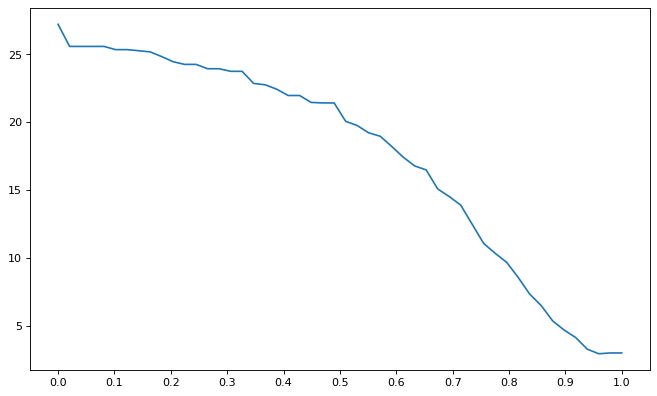

In [7]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

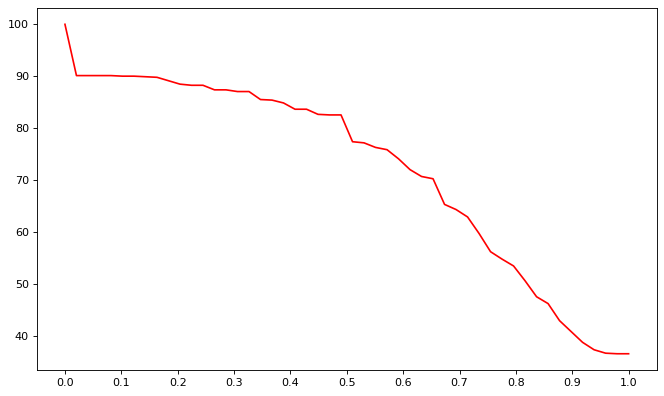

In [8]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

In [9]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : True,
}
kwargs = {
    "_filter": _filter, 
    "phoneme_words" : True,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : False
}
res = experiment_repeats(experiment, 5, bunches, **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

Desplitting phonemes and removing stress marks
Desplitting phonemes and removing stress marks
Desplitting phonemes and removing stress marks
Desplitting phonemes and removing stress marks
Desplitting phonemes and removing stress marks
google_wer: 0.24444444444444444±0.0
kb_wer: 0.0±0.0
correct-avg-length: 7.96875±0.0
google-avg-length: 7.416666666666667±0.0
kb-avg-length: 7.96875±0.0
lcs-mean: 0.7065582740631116±0.0


In [10]:
def init_phonemizer(device, model_path, stress_marks=True):
    checkpoint = torch.load(model_path, map_location=device)
    preprocessor = checkpoint['preprocessor']

    transformer = model.AutoregressiveTransformer(52, 77, d_fft=1024, d_model=512,
                                                  dropout=0.1, heads=4, encoder_layers=4, decoder_layers = 4, 
                                                  end_index=preprocessor.phoneme_tokenizer.end_index)

    
    transformer.load_state_dict(checkpoint['model'])

    pred = predictor.Predictor(transformer, preprocessor)
    phonemizer = Phonemizer(pred, None)

    return phonemizer

In [11]:
phonemizer("Hello my name is nick", lang="se")

'h\'elo m\'y2: n"a2:më \'i2:s n\'ik'

In [12]:
init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt', stress_marks=False)

In [16]:
set([phonemizer("ja", "se") for x in range(100)])

{"'a2:",
 "'j'a2:",
 "j'2",
 "j'2:",
 "j'a",
 "j'a2",
 "j'a2:",
 "j'a:",
 "j'ja2",
 'ja',
 'ja2',
 'ja2:',
 'ja:'}

In [17]:
set(phonemizer(["ja" for x in range(10000)], "se"))

{"j'a:"}

In [20]:
from random import sample
sample(range(10), k=5)

[3, 4, 8, 2, 0]

In [50]:
def phonemizer_eval(phonemizer):
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    keys_order = sample(keys_order, k=1000)
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    phonemes = get_swedish_phonemes(keys_order, phonemizer, include_stress_marks=True, batch_size=100)
    count_correct = 0
    for true,pred in tqdm(zip(values_order, phonemes)):
        if true==pred:
            count_correct += 1
    return {
        "accuracy" : count_correct / len(keys_order),
        "true" : values_order,
        "pred" : phonemes,
    }

In [51]:
experiment = phonemizer_eval
args = init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt')
res = experiment(phonemizer)

Preprocessing dict
Running phonemizer
Desplitting phonemes and removing stress marks


0it [00:00, ?it/s]

In [54]:
listaa = list(zip(res["true"], res["pred"]))

In [55]:
listaa[0]

(['j',
  '"',
  'ä3:',
  'rn',
  'v',
  'ä2:',
  'g',
  's',
  'e',
  'k',
  's',
  'p',
  'e',
  'd',
  'i',
  't',
  '`',
  'ö3',
  'r'],
 'j " ä3: rn v ä2: g s e k s p e d i t ` ö3 r')

In [43]:
res["pred"]

'm " a ng n e rs rt ` e2: n'

In [41]:
print_experiment_report(res)

accuracy: 0.0
true: ['m', '"', 'a', 'ng', 'n', 'e', 'rs', 'rt', '`', 'e2:', 'n']
pred: m " a ng n e rs rt ` e2: n


In [151]:
phonemizer = init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt')
#phonemizer = Phonemizer.from_checkpoint('models/deep-phonemizer-se.pt')
result = phonemizer('Jag hoppas att det nu finns korrekt betoning!', lang='se')
print(result)
result = phonemizer('ja ja', 'se')
print(result)
text = 'Vad kan vi göra för att förbättra det här systemet'

result = phonemizer(text, lang='se')

print(result)
for text, pred in result.predictions.items():
    tokens, probs = pred.phoneme_tokens, pred.token_probs
    for o, p in zip(tokens, probs):
        print(f'{o} {p}')
    tokens = ''.join(tokens)
    print(f'{text} | {tokens} | {pred.confidence}')

j'a2: h"åpas 'at d'e2:t n'u2: f'ins kor'ekt bet'o2:ning!
j'a2: j'a2:
v'a2:d k'a2:n v'i2: j"ö3ra f'ö3r 'at fö3rb'etra d'e h'ä3:r syst'e2:mët


AttributeError: 'str' object has no attribute 'predictions'

In [104]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [112]:
sorted_bunch_list = sorted(bunch_list, key=lambda x : wer(x["correct"], x["kb"]))

In [115]:
sorted_bunch_list.reverse()

In [116]:
sorted_bunch_list

[{'google': 'hejdå', 'correct': 'hejdå', 'kb': 'hej då'},
 {'google': 'får jag', 'correct': 'åhåjaja', 'kb': 'åjar jag'},
 {'google': 'ja då får jag', 'correct': 'ja åhåjaja', 'kb': 'ja var håja jag'},
 {'google': 'eurovision ikväll',
  'correct': 'eurovision ikväll',
  'kb': 'jurovisien i kväll'},
 {'google': 'nej', 'correct': 'ja', 'kb': 'na'},
 {'google': 'nej', 'correct': 'nä', 'kb': 'ne'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'a'},
 {'google': 'bellman', 'correct': 'men man', 'kb': 'meman'},
 {'google': 'nej', 'correct': 'näe', 'kb': 'nej'},
 {'google': 'nej', 'correct': 'näe', 'kb': 'nej'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'na'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'na'},
 {'google': 'jaha', 'correct': 'jaha', 'kb': 'ja'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'nå'},
 {'google': 'nej', 'correct': 'näe', 'kb': 'nej'},
 {'google': 'nej', 'correct': 'näe', 'kb': 'ne'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'na'},
 {'google': 'ja', 'correct': 'ja', 'kb': 'a'},


In [ ]:
str_a

In [ ]:
s.get_matching_blocks()

In [ ]:
google_lines.index("30")

In [ ]:
set(phonemizer(["jag" for x in range(10000)], "se"))

In [ ]:
set(get_swedish_phonemes(["ja" for x in range(10000)], phonemizer))

In [ ]:
s = []
for x in tqdm(range(1000)):
    torch.manual_seed(0)
    s.append(phonemizer('30', "se"))
set(s)

In [ ]:
s = []
for x in tqdm(range(15)):
    #torch.manual_seed(0)
    s.append(get_swedish_phonemes('ja', phonemizer))
set(s)

In [154]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

SyntaxError: invalid syntax (3878495266.py, line 2)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))